## Amazon Stock Price Prediction

Data Source: Yahoo Finance using `yfinance`module

**Index**

1. Data Extraction

2. Formatting data for time series

3. Feature engineering

4. ARIMA model

6. LSTM model with one feature

7. LSTM model with multiple features





In [135]:
# For first time users. Install yfinance for yahoo finance api
#pip install yfinance

#pip install xgboost

#pip install keras
#pip install tensorflow

In [56]:
#import math
#import time
import datetime

import pandas as pd
import numpy as np
import seaborn as sns

# import yahoo finance and other libraries
import yfinance as yf

#for plotting
import matplotlib.pyplot as plt
%matplotlib inline

#import any one scalar for normalizing data for LSTMs
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler

#evaluation metric
from sklearn.metrics import mean_squared_error, mean_absolute_error

#for feature selection
import xgboost as xgb

#to ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Fetch Amaznon AMZN stock data and arrange
ticker = yf.Ticker('AMZN')
df = ticker.history(start='2012-01-01', end='2022-01-01')
df = df.reset_index()
df['Date'] = pd.to_datetime(df['Date']).dt.date
df = df.iloc[:,0:5]
df.head()

,Date,Open,High,Low,Close
0,2012-01-03,8.7945,8.9740,8.7775,8.9515
1,2012-01-04,8.9605,9.0250,8.8035,8.8755
2,2012-01-05,8.7970,8.9125,8.7025,8.8805
3,2012-01-06,8.9035,9.2325,8.8750,9.1305
4,2012-01-09,9.1380,9.2185,8.8500,8.9280


In [45]:
#some useful commands can be found here: https://analyticsindiamag.com/hands-on-guide-to-using-yfinance-api-in-python/
ticker.recommendations

,Firm,To Grade,From Grade,Action
Date,,,,
2011-12-29 12:47:00,PiperJaffray,,,main
2012-02-15 07:33:00,PiperJaffray,Overweight,,main
2012-02-16 06:17:00,Morgan Stanley,Equal-Weight,,down
2012-04-02 06:06:00,Bank oferica,Neutral,,down
2012-04-27 06:21:00,Bank oferica,Buy,,up
...,...,...,...,...
2022-11-02 17:23:28,Tigress Financial,Buy,,main
2022-11-14 11:58:40,Rosenblatt,Neutral,,main
2022-11-15 12:46:44,MoffettNathanson,Outperform,,init


In [3]:
# for ARIMA we will only use one variable 'close'
adf = df.iloc[:,[0,4]]
adf.head(2)

,Date,Close
0,2012-01-03,8.9515
1,2012-01-04,8.8755


In [57]:
print('There are {} number of records in the dataset.'.format(df.shape[0]))

There are 2517 number of records in the dataset.


In [4]:
adf['Date']= pd.to_datetime(adf['Date'])
adf.dtypes

Date     datetime64[ns]
Close           float64
dtype: object

In [59]:
adf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2517 entries, 0 to 2516
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2517 non-null   datetime64[ns]
 1   Close   2517 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 39.5 KB


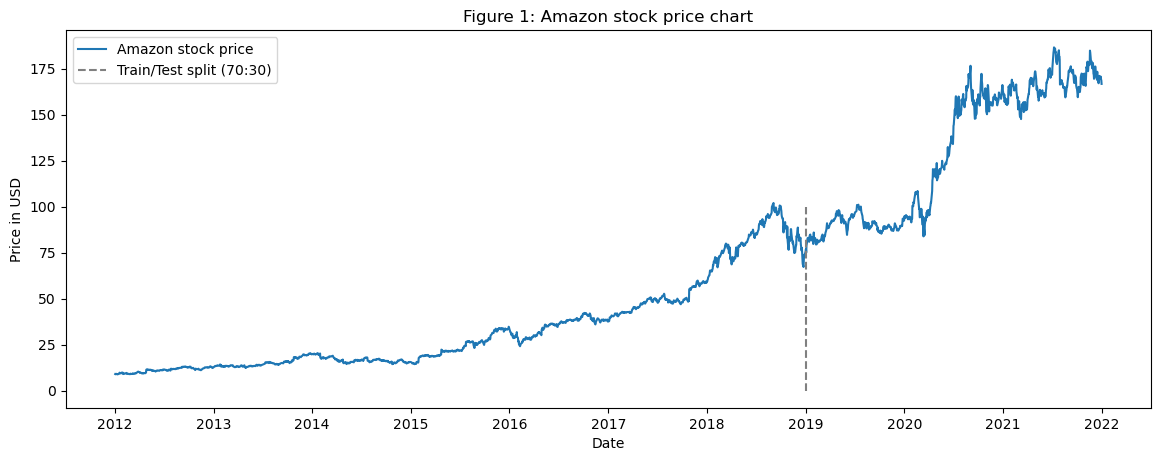

In [5]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(adf['Date'], adf['Close'], label='Amazon stock price')
plt.vlines(datetime.date(2019,1,3), 0,100, linestyles='--', colors='gray', label='Train/Test split (70:30)')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.title('Figure 1: Amazon stock price chart')
plt.legend()
plt.show()

# **Feature Engineering**

Let us create more technical indicators to help the model to learn more.

**1.   EMA:** An exponential moving average (EMA) is a type of moving average (MA) that places a greater weight and significance on the most recent data points.
<br/><br/>
*Formula and definition:* https://www.investopedia.com/terms/e/ema.asp


**2. Moving average ( 7 day and 21 day):** Moving averages are calculated to identify the trend direction of a stock or to determine its support and resistance levels. It is a trend-following or lagging, indicator because it is based on past prices.
<br/><br/>
*Formula and definition:* https://www.investopedia.com/terms/m/movingaverage.asp

**3. Momentum:** Momentum is the rate of acceleration of a security's price—that is, the speed at which the price is changing.
<br/><br/>
*Formula and definition:* https://www.investopedia.com/terms/m/marketmomentum.asp



In [6]:
#function to generate feature technical indicators

def technical_indicators(data): 
    
    
    # Create 7 and 21 days Moving Average
    data['MA7'] = data['Close'].rolling(window = 7).mean()
    data['MA21'] = data['Close'].rolling(window = 21).mean()
    
    #Create MACD
    data['12EMA'] = data['Close'].ewm(span=12).mean()
    data['26EMA'] = data['Close'].ewm(span=26).mean()
    data['MACD'] = (data['12EMA']-data['26EMA'])
    
    #Create Exponential moving average
    data['EMA'] = data['Close'].ewm(com=0.5).mean()
    
    #Create Momentum
    data['MOMENTUM'] = (data['Close']/100)-1
    
    return data

In [7]:
#create new dataframe
tdf = technical_indicators(df)
tdf.head()

,Date,Open,High,Low,Close,MA7,MA21,12EMA,26EMA,MACD,EMA,MOMENTUM
0,2012-01-03,8.7945,8.9740,8.7775,8.9515,NaN,NaN,8.951500,8.951500,0.000000,8.951500,-0.910485
1,2012-01-04,8.9605,9.0250,8.8035,8.8755,NaN,NaN,8.910333,8.912038,-0.001705,8.894500,-0.911245
2,2012-01-05,8.7970,8.9125,8.7025,8.8805,NaN,NaN,8.898689,8.900707,-0.002018,8.884808,-0.911195
3,2012-01-06,8.9035,9.2325,8.8750,9.1305,NaN,NaN,8.971863,8.964947,0.006916,9.050650,-0.908695
4,2012-01-09,9.1380,9.2185,8.8500,8.9280,NaN,NaN,8.959946,8.956379,0.003567,8.968546,-0.910720


# **ARIMA - Auto Regressive Integrated Moving Average** 
ARIMA predictions as a feature:

ARIMA is specified by theree order parameters (p,d,q)


**AR (p) Autoregression:** An auto regressive (AR(p)) component refers to the use of past values in the regression equation for the time series.
<br/><br/>


**I (d) Integration:** uses differencing of observations (subtracting an observation with an obseervation from the previous step) in order to make the time series stationary.
<br/><br/>


**MA (q) Moving Average:** A moving average component depicts the error of the model as a combination of previous error terms. The order q represents the number of terms to be included in the model.


**p: The number of lag observations included in the model, also called the lag order.**
**d: The number of times that the raw observations are differenced, also called the degree of differencing.**
**q: The size of the moving average window, also called the order of moving average.**

Learn how to calculate p,d,q here https://github.com/swapnilin/TS/blob/main/T2-Monthly-Forecasting-using-ARIMA.ipynb

 
**First, we will fit an ARIMA(5,1,0) model. This sets the lag value to 5 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0.**


In [8]:
dfa = df[['Date','Close']]

In [9]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = dfa['Close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2517
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -4597.837
Date:                Thu, 08 Dec 2022   AIC                           9207.674
Time:                        15:49:43   BIC                           9242.657
Sample:                             0   HQIC                          9220.370
                               - 2517                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0261      0.011     -2.474      0.013      -0.047      -0.005
ar.L2         -0.0064      0.010     -0.614      0.539      -0.027       0.014
ar.L3         -0.0756      0.009     -8.019      0.0

 **SUMMARY OF THE ARIMA MODEL**
 
**A good starting point for the AR parameter of the model may be 5 which we did**

**From the summary of the ARIMA we can see that most P-values are greater than 0.05.The model should be great!**

**The difference between AIC and BIC is low so this indicates this is a good model**


### Plot auto correlation plot

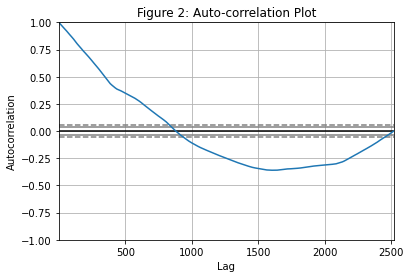

<Figure size 800x560 with 0 Axes>

In [10]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.title('Figure 2: Auto-correlation Plot')
plt.figure(figsize=(10, 7), dpi=80)
plt.show()


**We can see in figure 2, there is a positive correlation with the first 0 to 800 lags**


## Prepare and Train Data with ARIMA

In [11]:
series = dfa['Close']
X = series.values
size = int(len(X) * 0.70)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()

for i in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    new = test[i]
    history.append(new)

tdf['ARIMA'] = pd.DataFrame(predictions)

In [12]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 6.103


In [13]:
len(predictions), len(train)

(756, 1761)

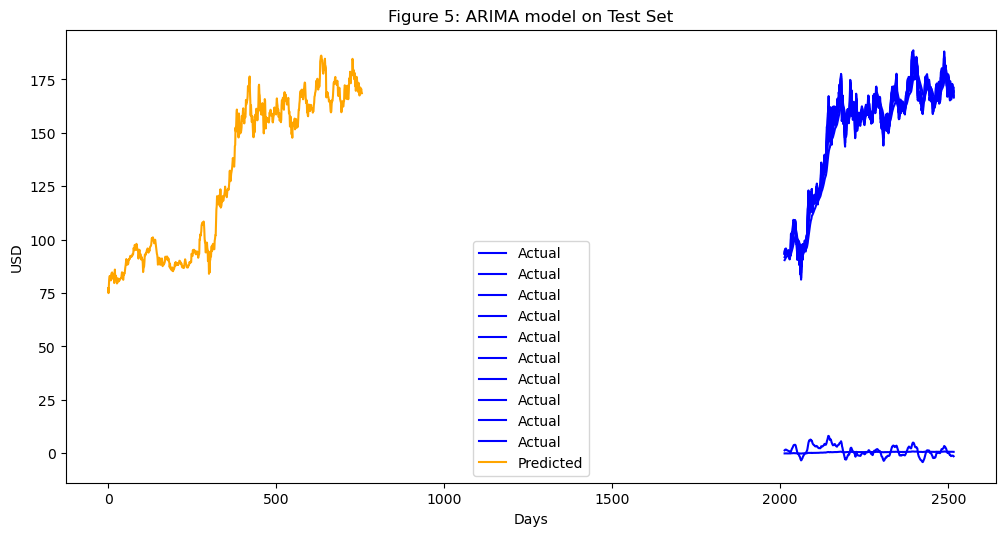

In [60]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, color='Blue', label='Actual')
plt.plot(predictions, color='Orange', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on Test Set')
plt.legend()
plt.show()

**As we can see from Figure 5 ARIMA gives a very good approximation of the real stock price. We will use the predicted price through ARIMA as an input feature into the LSTM.**

**Note: ARIMA values are only available for the size of test set, rest will show as NaN**

In [72]:
tdf

,Date,Open,High,Low,Close,MA7,MA21,12EMA,26EMA,MACD,EMA,MOMENTUM,ARIMA
0,2012-01-03,8.794500,8.974000,8.777500,8.951500,NaN,NaN,8.951500,8.951500,0.000000,8.951500,-0.910485,77.313624
1,2012-01-04,8.960500,9.025000,8.803500,8.875500,NaN,NaN,8.910333,8.912038,-0.001705,8.894500,-0.911245,74.981736
2,2012-01-05,8.797000,8.912500,8.702500,8.880500,NaN,NaN,8.898689,8.900707,-0.002018,8.884808,-0.911195,78.591700
3,2012-01-06,8.903500,9.232500,8.875000,9.130500,NaN,NaN,8.971863,8.964947,0.006916,9.050650,-0.908695,81.473986
4,2012-01-09,9.138000,9.218500,8.850000,8.928000,NaN,NaN,8.959946,8.956379,0.003567,8.968546,-0.910720,82.875644
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2512,2021-12-27,171.037003,172.942993,169.215500,169.669495,169.737071,172.019573,170.872064,172.005465,-1.133401,170.080147,0.696695,NaN
2513,2021-12-28,170.182495,172.175995,169.135498,170.660995,169.992785,171.802097,170.839592,171.905875,-1.066283,170.467379,0.706610,NaN
2514,2021-12-29,170.839996,171.212006,168.600494,169.201004,169.876142,171.379359,170.587501,171.705514,-1.118013,169.623129,0.692010,NaN
2515,2021-12-30,169.699997,170.888000,168.524002,168.644501,170.099786,171.059883,170.288578,171.478772,-1.190194,168.970710,0.686445,NaN


# **Feature Importance using XGBoost**

**Having so many features we have to consider whether all of them are really indicative of the direction AMZN stock will take. There are many ways to test feature importance, we will use XGBoost, because it gives one of the best results in both classification and regression problems.**

In [15]:
def features(data):
    data = data.copy()
    y = data['Close']
    X = df.drop(['Date','Close'], axis=1)
    
    train_samples = int(X.shape[0] * 0.70)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [16]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = features(df)

In [17]:
# find these hyper-parameters using grid search CV
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [18]:
#fit the model
xgbModel = regressor.fit(X_train_FI,y_train_FI,
                         eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)],
                         verbose=False)

In [19]:
eval_result = regressor.evals_result()

In [20]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

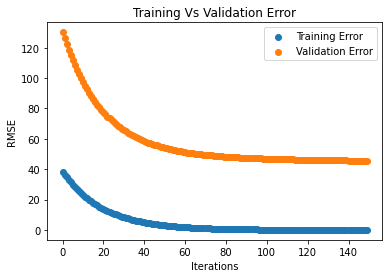

In [21]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

**The difference between validation and training error shows an underfit model. However, the way training and testing data is split, this is expected.**

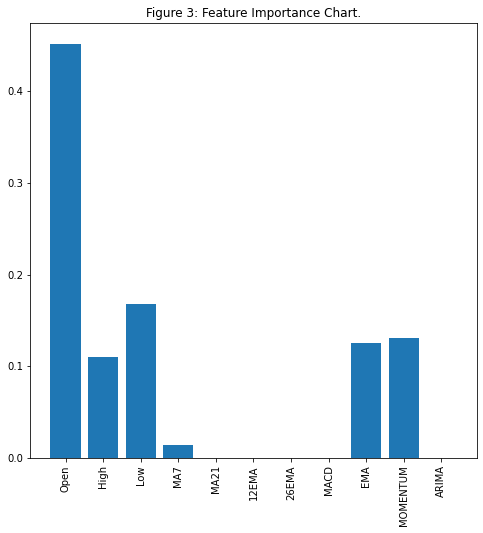

In [22]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 3: Feature Importance Chart.')
plt.show()

**MA7, EMA, and Momentum are among the important technical indicators** Features like Open, high, and low are bound to be close to Closing prices.


# **LSTM**

**LSTM is great at predicting stock market data. We are going to try to predict the closing prices, first using 1 feature Open(It has highest correlation to closing price) and then using multiple features**

**An LSTM Network has its origin in a RNN. But it can solve the memory loss by changing the neuron architecture.**

**The new neuron has 3 gates, each with a different goal. The gates are:**

**1.Input Gate**

**2.Output Gate**

**3.Forget Gate**

**An LSTM Neuron receives input from its previous state:**

How it works: You input the data one timestep at a time to the LSTM cell. And each timestep the cell not only recieves the new input, but it recieves the last timestep's output and what is called the cell state, a vector that carries information about what happened in the past. Within the cell you have trained gates (basically small neural nets) that decide, based on the three inputs, what to forget from the past cell state, what to remember (or add) to the new state, and what to output this timestep

![alt text](https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)




**Steps for LSTM**

**1. Clean up the data**

**2. Create a train, validate, and test set**

**3. Normalize data** 

**4. Create feature and label set**

**6. Train, validate data and check with test set**

**7. Make predictions**

**8. Based on this prediction find if the feature extraction method of LSTM works**



In [23]:
# Let us drop MA7 and MA21 since it has a lot of NaN's
lstm_df = df.drop(columns=['Date','MA7','MA21'])
lstm_df.head(7)

,Open,High,Low,Close,12EMA,26EMA,MACD,EMA,MOMENTUM,ARIMA
0,8.7945,8.9740,8.7775,8.9515,8.951500,8.951500,0.000000,8.951500,-0.910485,77.313624
1,8.9605,9.0250,8.8035,8.8755,8.910333,8.912038,-0.001705,8.894500,-0.911245,74.981736
2,8.7970,8.9125,8.7025,8.8805,8.898689,8.900707,-0.002018,8.884808,-0.911195,78.591700
3,8.9035,9.2325,8.8750,9.1305,8.971863,8.964947,0.006916,9.050650,-0.908695,81.473986
4,9.1380,9.2185,8.8500,8.9280,8.959946,8.956379,0.003567,8.968546,-0.910720,82.875644
5,9.0550,9.1200,8.8550,8.9670,8.961660,8.958506,0.003154,8.967514,-0.910330,82.722979
6,8.9820,9.0385,8.9095,8.9450,8.957942,8.956104,0.001838,8.952498,-0.910550,82.921498


In [24]:
#shape of the dataset
lstm_df.shape

(2517, 10)

In [25]:
#import keras layers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten

**Split dataset into train,test and validate sets**

In [26]:
#creating test, train and validate trains
train, validate, test = np.split(lstm_df, [int(.6*len(lstm_df)), int(.8*len(lstm_df))])

In [27]:
train.shape, validate.shape, test.shape

((1510, 10), (503, 10), (504, 10))

### Model with only one variable 'Open'

In [28]:
# create arrays
opentrain = train.iloc[:, 0:1].values
openval= validate.iloc[:,0:1].values
opentest = test.iloc[:,0:1].values

**Normalization**
The data is not normalized and the range for each column varies. Normalizing data helps the algorithm in converging i.e. to find local/ global minimum efficiently. I will use MinMaxScaler from Sci-kit Learn. 

In [29]:
#normalise using min-max scalar
scaler = MinMaxScaler(feature_range = (0, 1))
sopentrain = scaler.fit_transform(opentrain)
sopenval = scaler.fit_transform(openval)
sopentest = scaler.fit_transform(opentest)

We cannot fit the model like we normally do using ARIMA. We need to transform our data into something that looks like X and Y values.
This way it can be trained on a sequence rather than individual datapoints. 
Let us convert into n number of columns for X where we feed sequence of numbers then the final column as Y where we provide the next number in the sequence as output.
So let us convert an array (open-training) of values into a dataset matrix.

In [30]:
# use a simple for loop

def to_table(data, seq_size):
    x = []
    y = []

    for i in range(len(data)-seq_size):
        window = data[i:(i+seq_size), 0]
        x.append(window)
        y.append(data[i+seq_size, 0])
        
    return pd.DataFrame(x), pd.DataFrame(y)

In [31]:
# Re-arrange train data
traindata = to_table(sopentrain, seq_size=3)
valdata = to_table(sopenval, seq_size=3)
testdata = to_table(sopentest, seq_size=3)


In [32]:
# the open data column has now been arranged in 4 columns, first 3 are the independant variables and the 4th is the dependant variable
traindata

(             0         1         2
 0     0.002017  0.005237  0.002066
 1     0.005237  0.002066  0.004132
 2     0.002066  0.004132  0.008680
 3     0.004132  0.008680  0.007070
 4     0.008680  0.007070  0.005654
 ...        ...       ...       ...
 1502  0.986053  0.971893  0.968188
 1503  0.971893  0.968188  0.964580
 1504  0.968188  0.964580  0.975782
 1505  0.964580  0.975782  0.984599
 1506  0.975782  0.984599  0.978149
 
 [1507 rows x 3 columns],
              0
 0     0.004132
 1     0.008680
 2     0.007070
 3     0.005654
 4     0.005441
 ...        ...
 1502  0.964580
 1503  0.975782
 1504  0.984599
 1505  0.978149
 1506  0.968111
 
 [1507 rows x 1 columns])

In [33]:
# seperate independant and dependant variables and typecast it to array type since it is a requirement for LSTM in keras
x_train = np.array(traindata[0])
y_train=np.array(traindata[1])
x_val = np.array(valdata[0])
y_val = np.array(valdata[1])
x_test = np.array(testdata[0])
y_test = np.array(testdata[1])

In [35]:
x_train.shape, y_train.shape

((1507, 3), (1507, 1))

**Convert feature set and label set into arrays and shape feature set into a 3D input that LSTM network demands**

In [36]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
train_x = np.reshape(x_train, (x_train.shape[0],x_train.shape[1], 1)) #[samples, timesteps, features]
val_x = np.reshape(x_val, (x_val.shape[0],x_val.shape[1], 1)) #[samples, timesteps, features]

In [49]:
#instantiate and fit the model

#model.reset_states()
model = Sequential()
model.add(LSTM(15, input_shape=(3, 1), activation='relu', return_sequences=True)) # 3 is the timesteps, 1 is the one from the reshape 
#model.add(Dropout(0.2))
model.add(Flatten()) #converting multi-dimensional array into one dimensional flatten array
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
print(model.summary())

# fit the model
#del history
#set verbose=False if you don't want to see the output
history = model.fit(train_x, y_train, epochs = 100, batch_size = 32,validation_data = (val_x, y_val))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 3, 15)             1020      
                                                                 
 flatten (Flatten)           (None, 45)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 46        
                                                                 
Total params: 1,066
Trainable params: 1,066
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
48/48 [==============================] - 1s 6ms/step - loss: 0.1180 - mean_absolute_error: 0.2516 - val_loss: 0.1987 - val_mean_absolute_error: 0.4187
Epoch 2/100
48/48 [==============================] - 0s 2ms/step - loss: 0.0392 - mean_absolute_error: 0.1390 - val_loss: 0.0233 - val_mean_absolute

48/48 [==============================] - 0s 2ms/step - loss: 1.3734e-04 - mean_absolute_error: 0.0077 - val_loss: 0.0023 - val_mean_absolute_error: 0.0359
Epoch 46/100
48/48 [==============================] - 0s 2ms/step - loss: 1.3584e-04 - mean_absolute_error: 0.0077 - val_loss: 0.0023 - val_mean_absolute_error: 0.0356
Epoch 47/100
48/48 [==============================] - 0s 2ms/step - loss: 1.4283e-04 - mean_absolute_error: 0.0079 - val_loss: 0.0023 - val_mean_absolute_error: 0.0355
Epoch 48/100
48/48 [==============================] - 0s 2ms/step - loss: 1.3793e-04 - mean_absolute_error: 0.0077 - val_loss: 0.0023 - val_mean_absolute_error: 0.0357
Epoch 49/100
48/48 [==============================] - 0s 2ms/step - loss: 1.3677e-04 - mean_absolute_error: 0.0077 - val_loss: 0.0023 - val_mean_absolute_error: 0.0356
Epoch 50/100
48/48 [==============================] - 0s 3ms/step - loss: 1.3553e-04 - mean_absolute_error: 0.0077 - val_loss: 0.0023 - val_mean_absolute_error: 0.0356
Epoch

Epoch 94/100
48/48 [==============================] - 0s 3ms/step - loss: 1.2654e-04 - mean_absolute_error: 0.0074 - val_loss: 0.0022 - val_mean_absolute_error: 0.0346
Epoch 95/100
48/48 [==============================] - 0s 3ms/step - loss: 1.2932e-04 - mean_absolute_error: 0.0075 - val_loss: 0.0022 - val_mean_absolute_error: 0.0341
Epoch 96/100
48/48 [==============================] - 0s 3ms/step - loss: 1.2839e-04 - mean_absolute_error: 0.0075 - val_loss: 0.0021 - val_mean_absolute_error: 0.0342
Epoch 97/100
48/48 [==============================] - 0s 3ms/step - loss: 1.2691e-04 - mean_absolute_error: 0.0073 - val_loss: 0.0021 - val_mean_absolute_error: 0.0341
Epoch 98/100
48/48 [==============================] - 0s 2ms/step - loss: 1.2627e-04 - mean_absolute_error: 0.0075 - val_loss: 0.0022 - val_mean_absolute_error: 0.0339
Epoch 99/100
48/48 [==============================] - 0s 2ms/step - loss: 1.2945e-04 - mean_absolute_error: 0.0077 - val_loss: 0.0021 - val_mean_absolute_error:

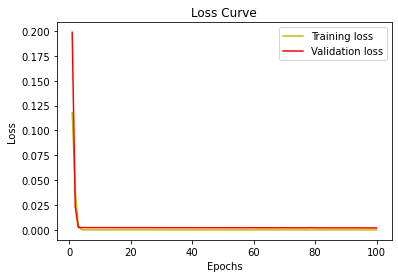

In [50]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [40]:
x_train.shape, x_val.shape

((1507, 3), (500, 3))

(1507, 3)

**MAE: This means that the average difference between input and ouput for all 1507 datapoints is 0.002. Which is good.
The value is for the days here so 1507 length of train set will be denominator. Which means, the difference between actual and prediced values is small that such a large denominator dividing the difference puts MAE in rage of 10^-3 i.e. 0.00xxx**

**Same for the validation set. We will now make predictions and check how the model performs on the test set**

### Making Predictions on Test set

In [51]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
test_x = np.reshape(x_test, (x_test.shape[0],x_test.shape[1], 1)) #[samples, timesteps, features]

In [52]:
# make predictions
trainpredict = model.predict(train_x)
testpredict = model.predict(test_x)

16/16 [==============================] - 0s 1ms/step


In [53]:
test_x.shape, trainpredict.shape

((501, 3, 1), (1507, 1))

In [54]:
# rescale all the observations
trainpredict = scaler.inverse_transform(trainpredict)
testpredict = scaler.inverse_transform(testpredict)
x_train1 = scaler.inverse_transform(x_train)
y_train1 = scaler.inverse_transform(y_train)
x_test1 = scaler.inverse_transform(x_test)
y_test1 = scaler.inverse_transform(y_test)

In [63]:
# Evaluate the model
print('Single variable LSTM MAE = ', mean_absolute_error(y_test1, testpredict))

Single variable LSTM MAE =  2.7273968755604026


**Plot the prediction model for the number of test days and train days**

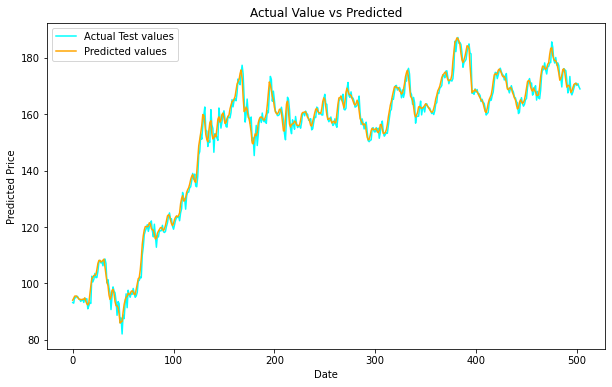

In [62]:
plt.figure(figsize=(10,6))
plt.plot(opentest, color='Cyan', label='Actual Test values')
plt.plot(testpredict , color='Orange', label='Predicted values')
plt.title('Actual Value vs Predicted')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()


### **Using more than one feature**


**We will try LSTM with the best 5 features from the result of the xgboost deature selection. We can than compare the MAE's to check whether more features improves the model.**

In [68]:
lstm_df.head(2)

,Open,High,Low,Close,12EMA,26EMA,MACD,EMA,MOMENTUM,ARIMA
0,8.7945,8.974,8.7775,8.9515,8.951500,8.951500,0.000000,8.9515,-0.910485,77.313624
1,8.9605,9.025,8.8035,8.8755,8.910333,8.912038,-0.001705,8.8945,-0.911245,74.981736


In [69]:
data = lstm_df[['Open','Close','High','Low', 'EMA', 'MOMENTUM']]

In [66]:
data.head()

,Open,Close,High,Low,EMA,MOMENTUM
0,8.7945,8.9515,8.9740,8.7775,8.951500,-0.910485
1,8.9605,8.8755,9.0250,8.8035,8.894500,-0.911245
2,8.7970,8.8805,8.9125,8.7025,8.884808,-0.911195
3,8.9035,9.1305,9.2325,8.8750,9.050650,-0.908695
4,9.1380,8.9280,9.2185,8.8500,8.968546,-0.910720


### Split dataset into train, test and validate sets

In [75]:
#creating test, train and validate trains
train, val, test = np.split(data, [int(.6*len(lstm_df)), int(.8*len(lstm_df))])

In [76]:
train.shape, validate.shape, test.shape

((1510, 6), (503, 6), (504, 6))

### Normalize the data

In [77]:
#normalise using min-max scalar
scaler = MinMaxScaler(feature_range = (0, 1))
strain = scaler.fit_transform(train)
sval = scaler.fit_transform(val)
stest = scaler.fit_transform(test)

In [87]:
# For train
Xtrain = []
Ytrain = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 3

#Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(strain) - n_future +1):
    Xtrain.append(strain[i - n_past:i, 0:df.shape[1]])
    Ytrain.append(strain[i + n_future - 1:i + n_future, 0])


In [89]:
# For val
Xval = []
Yval = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 3

#Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(strain) - n_future +1):
    Xval.append(strain[i - n_past:i, 0:df.shape[1]])
    Yval.append(strain[i + n_future - 1:i + n_future, 0])

In [90]:
# For train
Xtest = []
Ytest = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 3

#Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(strain) - n_future +1):
    Xtest.append(strain[i - n_past:i, 0:df.shape[1]])
    Ytest.append(strain[i + n_future - 1:i + n_future, 0])

In [91]:
# change type to array
Xtrain, Ytrain = np.array(Xtrain), np.array(Ytrain)
Xval, Yval = np.array(Xval), np.array(Yval)
Xtest, Ytest = np.array(Xtest), np.array(Ytest)

Xtrain.shape,Ytrain.shape


((1507, 3, 6), (1507, 1))

In [95]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
train_X = np.reshape(Xtrain, (Xtrain.shape[0],Xtrain.shape[1], 6)) #[samples, timesteps, features]
val_X = np.reshape(Xval, (Xval.shape[0],Xval.shape[1], 6))

### LSTM Model

In [98]:
#instantiate and fit the model

model.reset_states()
model = Sequential()
model.add(LSTM(15, input_shape=(3, 6), activation='relu', return_sequences=True)) # 3 is the timesteps, 1 is the one from the reshape 
#model.add(Dropout(0.2))
model.add(Flatten()) #converting multi-dimensional array into one dimensional flatten array
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
print(model.summary())

# fit the model
#del history
#set verbose=False if you don't want to see the output
history = model.fit(train_X, Ytrain, epochs = 100, batch_size = 32,validation_data = (val_X, Yval))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 3, 15)             1320      
                                                                 
 flatten_4 (Flatten)         (None, 45)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 46        
                                                                 
Total params: 1,366
Trainable params: 1,366
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
48/48 [==============================] - 1s 7ms/step - loss: 0.1153 - mean_absolute_error: 0.2423 - val_loss: 0.0342 - val_mean_absolute_error: 0.1274
Epoch 2/100
48/48 [==============================] - 0s 3ms/step - loss: 0.0077 - mean_absolute_error: 0.0539 - val_loss: 3.9323e-04 - val_mean_abso

Epoch 44/100
48/48 [==============================] - 0s 3ms/step - loss: 1.0549e-04 - mean_absolute_error: 0.0065 - val_loss: 1.0700e-04 - val_mean_absolute_error: 0.0066
Epoch 45/100
48/48 [==============================] - 0s 3ms/step - loss: 1.0641e-04 - mean_absolute_error: 0.0065 - val_loss: 1.0800e-04 - val_mean_absolute_error: 0.0065
Epoch 46/100
48/48 [==============================] - 0s 3ms/step - loss: 1.1402e-04 - mean_absolute_error: 0.0069 - val_loss: 1.4251e-04 - val_mean_absolute_error: 0.0085
Epoch 47/100
48/48 [==============================] - 0s 3ms/step - loss: 1.0745e-04 - mean_absolute_error: 0.0067 - val_loss: 1.0417e-04 - val_mean_absolute_error: 0.0065
Epoch 48/100
48/48 [==============================] - 0s 3ms/step - loss: 1.0976e-04 - mean_absolute_error: 0.0067 - val_loss: 1.3046e-04 - val_mean_absolute_error: 0.0074
Epoch 49/100
48/48 [==============================] - 0s 3ms/step - loss: 1.1213e-04 - mean_absolute_error: 0.0068 - val_loss: 1.0203e-04 - 

48/48 [==============================] - 0s 3ms/step - loss: 8.5860e-05 - mean_absolute_error: 0.0059 - val_loss: 8.9878e-05 - val_mean_absolute_error: 0.0065
Epoch 92/100
48/48 [==============================] - 0s 3ms/step - loss: 8.0922e-05 - mean_absolute_error: 0.0056 - val_loss: 7.5949e-05 - val_mean_absolute_error: 0.0053
Epoch 93/100
48/48 [==============================] - 0s 3ms/step - loss: 7.8785e-05 - mean_absolute_error: 0.0056 - val_loss: 7.5362e-05 - val_mean_absolute_error: 0.0052
Epoch 94/100
48/48 [==============================] - 0s 3ms/step - loss: 8.0366e-05 - mean_absolute_error: 0.0056 - val_loss: 1.0735e-04 - val_mean_absolute_error: 0.0069
Epoch 95/100
48/48 [==============================] - 0s 3ms/step - loss: 1.0632e-04 - mean_absolute_error: 0.0069 - val_loss: 9.1050e-05 - val_mean_absolute_error: 0.0060
Epoch 96/100
48/48 [==============================] - 0s 3ms/step - loss: 8.2194e-05 - mean_absolute_error: 0.0057 - val_loss: 1.0380e-04 - val_mean_abso

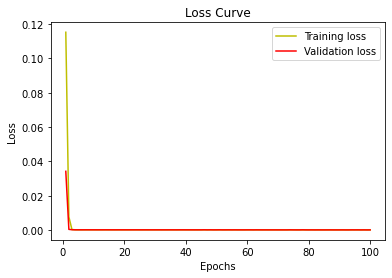

In [99]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**MAE: This means that the average difference between input and ouput for all 1507 datapoints is 0.005. Which is good.
The value is for the days here so 1507 length of train set will be denominator. Which means, the difference between actual and prediced values is small that such a large denominator dividing the difference puts MAE in rage of 10^-3 i.e. 0.00xxx**

**Same for the validation set. We will now make predictions and check how the model performs on the test set**

### Making Predictions on Test set

In [100]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
test_X = np.reshape(Xtest, (Xtest.shape[0],Xtest.shape[1], 6)) #[samples, timesteps, features]

In [101]:
# make predictions
testpredict = model.predict(test_X)

48/48 [==============================] - 0s 1ms/step


In [103]:
test_X.shape, testpredict.shape

((1507, 3, 6), (1507, 1))

In [105]:
testpredict

array([[0.00476338],
       [0.00617997],
       [0.0068562 ],
       ...,
       [0.9686061 ],
       [0.972387  ],
       [0.9665477 ]], dtype=float32)

In [109]:
# rescale all the observations
test_prediction_copies = np.repeat(testpredict, 6, axis=-1)
testpred = scaler.inverse_transform(test_prediction_copies)[:,0]
testpred

array([ 82.57625,  82.72517,  82.79625, ..., 183.89973, 184.2972 ,
       183.68335], dtype=float32)

**Plot the prediction model for the number of test days and train days**

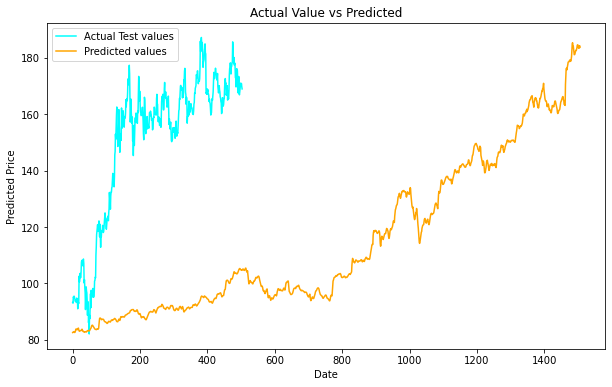

In [112]:
plt.figure(figsize=(10,6))
plt.plot(opentest, color='Cyan', label='Actual Test values')
plt.plot(testpred , color='Orange', label='Predicted values')
plt.title('Actual Value vs Predicted')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()


### **Using more than one feature**


**We will try LSTM with the best 5 features from the result of the xgboost deature selection. We can than compare the MAE's to check whether more features improves the model.**

In [68]:
lstm_df.head(2)

,Open,High,Low,Close,12EMA,26EMA,MACD,EMA,MOMENTUM,ARIMA
0,8.7945,8.974,8.7775,8.9515,8.951500,8.951500,0.000000,8.9515,-0.910485,77.313624
1,8.9605,9.025,8.8035,8.8755,8.910333,8.912038,-0.001705,8.8945,-0.911245,74.981736


In [69]:
data = lstm_df[['Open','Close','High','Low', 'EMA', 'MOMENTUM']]

In [66]:
data.head()

,Open,Close,High,Low,EMA,MOMENTUM
0,8.7945,8.9515,8.9740,8.7775,8.951500,-0.910485
1,8.9605,8.8755,9.0250,8.8035,8.894500,-0.911245
2,8.7970,8.8805,8.9125,8.7025,8.884808,-0.911195
3,8.9035,9.1305,9.2325,8.8750,9.050650,-0.908695
4,9.1380,8.9280,9.2185,8.8500,8.968546,-0.910720


### Split dataset into train, test and validate sets

In [75]:
#creating test, train and validate trains
train, val, test = np.split(data, [int(.6*len(lstm_df)), int(.8*len(lstm_df))])

In [76]:
train.shape, validate.shape, test.shape

((1510, 6), (503, 6), (504, 6))

### Normalize the data

In [77]:
#normalise using min-max scalar
scaler = MinMaxScaler(feature_range = (0, 1))
strain = scaler.fit_transform(train)
sval = scaler.fit_transform(val)
stest = scaler.fit_transform(test)

In [87]:
# For train
Xtrain = []
Ytrain = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 3

#Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(strain) - n_future +1):
    Xtrain.append(strain[i - n_past:i, 0:df.shape[1]])
    Ytrain.append(strain[i + n_future - 1:i + n_future, 0])


In [89]:
# For val
Xval = []
Yval = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 3

#Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(strain) - n_future +1):
    Xval.append(strain[i - n_past:i, 0:df.shape[1]])
    Yval.append(strain[i + n_future - 1:i + n_future, 0])

In [90]:
# For train
Xtest = []
Ytest = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 3

#Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(strain) - n_future +1):
    Xtest.append(strain[i - n_past:i, 0:df.shape[1]])
    Ytest.append(strain[i + n_future - 1:i + n_future, 0])

In [91]:
# change type to array
Xtrain, Ytrain = np.array(Xtrain), np.array(Ytrain)
Xval, Yval = np.array(Xval), np.array(Yval)
Xtest, Ytest = np.array(Xtest), np.array(Ytest)

Xtrain.shape,Ytrain.shape


((1507, 3, 6), (1507, 1))

In [95]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
train_X = np.reshape(Xtrain, (Xtrain.shape[0],Xtrain.shape[1], 6)) #[samples, timesteps, features]
val_X = np.reshape(Xval, (Xval.shape[0],Xval.shape[1], 6))

### LSTM Model

In [118]:
#instantiate and fit the model

model.reset_states()
model = Sequential()
model.add(LSTM(15, input_shape=(3, 6), activation='relu', return_sequences=True)) # 3 is the timesteps, 1 is the one from the reshape 
#model.add(Dropout(0.2))
model.add(Flatten()) #converting multi-dimensional array into one dimensional flatten array
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
print(model.summary())

# fit the model
#del history
#set verbose=False if you don't want to see the output
history = model.fit(train_X, Ytrain, epochs = 100, batch_size = 32,validation_data = (val_X, Yval))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 3, 15)             1320      
                                                                 
 flatten_6 (Flatten)         (None, 45)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 46        
                                                                 
Total params: 1,366
Trainable params: 1,366
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
48/48 [==============================] - 1s 7ms/step - loss: 0.0440 - mean_absolute_error: 0.1390 - val_loss: 0.0027 - val_mean_absolute_error: 0.0442
Epoch 2/100
48/48 [==============================] - 0s 3ms/step - loss: 0.0017 - mean_absolute_error: 0.0341 - val_loss: 3.4538e-04 - val_mean_abso

Epoch 44/100
48/48 [==============================] - 0s 3ms/step - loss: 1.1685e-04 - mean_absolute_error: 0.0068 - val_loss: 1.1375e-04 - val_mean_absolute_error: 0.0066
Epoch 45/100
48/48 [==============================] - 0s 3ms/step - loss: 1.1565e-04 - mean_absolute_error: 0.0067 - val_loss: 1.1781e-04 - val_mean_absolute_error: 0.0068
Epoch 46/100
48/48 [==============================] - 0s 3ms/step - loss: 1.1420e-04 - mean_absolute_error: 0.0067 - val_loss: 1.1228e-04 - val_mean_absolute_error: 0.0065
Epoch 47/100
48/48 [==============================] - 0s 3ms/step - loss: 1.1690e-04 - mean_absolute_error: 0.0068 - val_loss: 1.2962e-04 - val_mean_absolute_error: 0.0074
Epoch 48/100
48/48 [==============================] - 0s 3ms/step - loss: 1.1780e-04 - mean_absolute_error: 0.0069 - val_loss: 1.1033e-04 - val_mean_absolute_error: 0.0065
Epoch 49/100
48/48 [==============================] - 0s 3ms/step - loss: 1.1490e-04 - mean_absolute_error: 0.0067 - val_loss: 1.1700e-04 - 

48/48 [==============================] - 0s 3ms/step - loss: 9.4490e-05 - mean_absolute_error: 0.0061 - val_loss: 9.1701e-05 - val_mean_absolute_error: 0.0059
Epoch 92/100
48/48 [==============================] - 0s 3ms/step - loss: 9.4265e-05 - mean_absolute_error: 0.0060 - val_loss: 9.0153e-05 - val_mean_absolute_error: 0.0058
Epoch 93/100
48/48 [==============================] - 0s 3ms/step - loss: 1.1327e-04 - mean_absolute_error: 0.0070 - val_loss: 9.1453e-05 - val_mean_absolute_error: 0.0059
Epoch 94/100
48/48 [==============================] - 0s 3ms/step - loss: 9.6882e-05 - mean_absolute_error: 0.0061 - val_loss: 1.0883e-04 - val_mean_absolute_error: 0.0071
Epoch 95/100
48/48 [==============================] - 0s 3ms/step - loss: 9.2911e-05 - mean_absolute_error: 0.0059 - val_loss: 8.8647e-05 - val_mean_absolute_error: 0.0057
Epoch 96/100
48/48 [==============================] - 0s 3ms/step - loss: 9.2721e-05 - mean_absolute_error: 0.0060 - val_loss: 8.8853e-05 - val_mean_abso

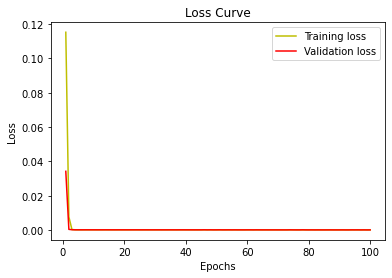

In [99]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**MAE: This means that the average difference between input and ouput for all 1507 datapoints is 0.005. Which is good.
The value is for the days here so 1507 length of train set will be denominator. Which means, the difference between actual and prediced values is small that such a large denominator dividing the difference puts MAE in rage of 10^-3 i.e. 0.00xxx**

**Same for the validation set. We will now make predictions and check how the model performs on the test set**

### Making Predictions on Test set

In [100]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
test_X = np.reshape(Xtest, (Xtest.shape[0],Xtest.shape[1], 6)) #[samples, timesteps, features]

In [101]:
# make predictions
testpredict = model.predict(test_X)

48/48 [==============================] - 0s 1ms/step


In [103]:
test_X.shape, testpredict.shape

((1507, 3, 6), (1507, 1))

In [105]:
testpredict

array([[0.00476338],
       [0.00617997],
       [0.0068562 ],
       ...,
       [0.9686061 ],
       [0.972387  ],
       [0.9665477 ]], dtype=float32)

In [109]:
# rescale all the observations
test_prediction_copies = np.repeat(testpredict, 6, axis=-1)
testpred = scaler.inverse_transform(test_prediction_copies)[:,0]
testpred

array([ 82.57625,  82.72517,  82.79625, ..., 183.89973, 184.2972 ,
       183.68335], dtype=float32)

In [114]:
# Evaluate the model
print('Multi variable LSTM MAE = ', mean_absolute_error(Ytest, testpred))

Multi variable LSTM MAE =  114.75333023597811


**Plot the prediction model for the number of test days and train days**

In [116]:
testpred.shape

(1507,)

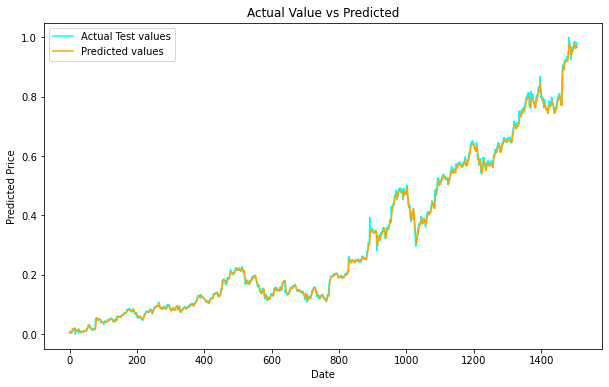

In [113]:
plt.figure(figsize=(10,6))
plt.plot(Ytest, color='Cyan', label='Actual Test values')
plt.plot(testpredict , color='Orange', label='Predicted values')
plt.title('Actual Value vs Predicted')
plt.xlabel('Date')
plt.ylabel('Predicted Price')
plt.legend()
plt.show()


### **Using more than one feature**


**We will try LSTM with the best 5 features from the result of the xgboost deature selection. We can than compare the MAE's to check whether more features improves the model.**

In [68]:
lstm_df.head(2)

,Open,High,Low,Close,12EMA,26EMA,MACD,EMA,MOMENTUM,ARIMA
0,8.7945,8.974,8.7775,8.9515,8.951500,8.951500,0.000000,8.9515,-0.910485,77.313624
1,8.9605,9.025,8.8035,8.8755,8.910333,8.912038,-0.001705,8.8945,-0.911245,74.981736


In [69]:
data = lstm_df[['Open','Close','High','Low', 'EMA', 'MOMENTUM']]

In [66]:
data.head()

,Open,Close,High,Low,EMA,MOMENTUM
0,8.7945,8.9515,8.9740,8.7775,8.951500,-0.910485
1,8.9605,8.8755,9.0250,8.8035,8.894500,-0.911245
2,8.7970,8.8805,8.9125,8.7025,8.884808,-0.911195
3,8.9035,9.1305,9.2325,8.8750,9.050650,-0.908695
4,9.1380,8.9280,9.2185,8.8500,8.968546,-0.910720


### Split dataset into train, test and validate sets

In [75]:
#creating test, train and validate trains
train, val, test = np.split(data, [int(.6*len(lstm_df)), int(.8*len(lstm_df))])

In [76]:
train.shape, validate.shape, test.shape

((1510, 6), (503, 6), (504, 6))

### Normalize the data

In [77]:
#normalise using min-max scalar
scaler = MinMaxScaler(feature_range = (0, 1))
strain = scaler.fit_transform(train)
sval = scaler.fit_transform(val)
stest = scaler.fit_transform(test)

In [87]:
# For train
Xtrain = []
Ytrain = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 3

#Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(strain) - n_future +1):
    Xtrain.append(strain[i - n_past:i, 0:df.shape[1]])
    Ytrain.append(strain[i + n_future - 1:i + n_future, 0])


In [89]:
# For val
Xval = []
Yval = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 3

#Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(strain) - n_future +1):
    Xval.append(strain[i - n_past:i, 0:df.shape[1]])
    Yval.append(strain[i + n_future - 1:i + n_future, 0])

In [90]:
# For train
Xtest = []
Ytest = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 3

#Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(strain) - n_future +1):
    Xtest.append(strain[i - n_past:i, 0:df.shape[1]])
    Ytest.append(strain[i + n_future - 1:i + n_future, 0])

In [91]:
# change type to array
Xtrain, Ytrain = np.array(Xtrain), np.array(Ytrain)
Xval, Yval = np.array(Xval), np.array(Yval)
Xtest, Ytest = np.array(Xtest), np.array(Ytest)

Xtrain.shape,Ytrain.shape


((1507, 3, 6), (1507, 1))

In [95]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
train_X = np.reshape(Xtrain, (Xtrain.shape[0],Xtrain.shape[1], 6)) #[samples, timesteps, features]
val_X = np.reshape(Xval, (Xval.shape[0],Xval.shape[1], 6))

### LSTM Model

In [98]:
#instantiate and fit the model

model.reset_states()
model = Sequential()
model.add(LSTM(15, input_shape=(3, 6), activation='relu', return_sequences=True)) # 3 is the timesteps, 1 is the one from the reshape 
#model.add(Dropout(0.2))
model.add(Flatten()) #converting multi-dimensional array into one dimensional flatten array
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_absolute_error'])
print(model.summary())

# fit the model
#del history
#set verbose=False if you don't want to see the output
history = model.fit(train_X, Ytrain, epochs = 100, batch_size = 32,validation_data = (val_X, Yval))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 3, 15)             1320      
                                                                 
 flatten_4 (Flatten)         (None, 45)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 46        
                                                                 
Total params: 1,366
Trainable params: 1,366
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
48/48 [==============================] - 1s 7ms/step - loss: 0.1153 - mean_absolute_error: 0.2423 - val_loss: 0.0342 - val_mean_absolute_error: 0.1274
Epoch 2/100
48/48 [==============================] - 0s 3ms/step - loss: 0.0077 - mean_absolute_error: 0.0539 - val_loss: 3.9323e-04 - val_mean_abso

Epoch 44/100
48/48 [==============================] - 0s 3ms/step - loss: 1.0549e-04 - mean_absolute_error: 0.0065 - val_loss: 1.0700e-04 - val_mean_absolute_error: 0.0066
Epoch 45/100
48/48 [==============================] - 0s 3ms/step - loss: 1.0641e-04 - mean_absolute_error: 0.0065 - val_loss: 1.0800e-04 - val_mean_absolute_error: 0.0065
Epoch 46/100
48/48 [==============================] - 0s 3ms/step - loss: 1.1402e-04 - mean_absolute_error: 0.0069 - val_loss: 1.4251e-04 - val_mean_absolute_error: 0.0085
Epoch 47/100
48/48 [==============================] - 0s 3ms/step - loss: 1.0745e-04 - mean_absolute_error: 0.0067 - val_loss: 1.0417e-04 - val_mean_absolute_error: 0.0065
Epoch 48/100
48/48 [==============================] - 0s 3ms/step - loss: 1.0976e-04 - mean_absolute_error: 0.0067 - val_loss: 1.3046e-04 - val_mean_absolute_error: 0.0074
Epoch 49/100
48/48 [==============================] - 0s 3ms/step - loss: 1.1213e-04 - mean_absolute_error: 0.0068 - val_loss: 1.0203e-04 - 

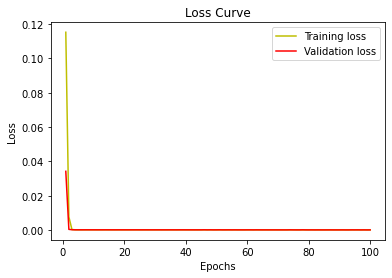

In [99]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

**MAE: This means that the average difference between input and ouput for all 1507 datapoints is 0.005. Which is good.
The value is for the days here so 1507 length of train set will be denominator. Which means, the difference between actual and prediced values is small that such a large denominator dividing the difference puts MAE in rage of 10^-3 i.e. 0.00xxx**

**Same for the validation set. We will now make predictions and check how the model performs on the test set**

### Making Predictions on Test set

In [100]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
test_X = np.reshape(Xtest, (Xtest.shape[0],Xtest.shape[1], 6)) #[samples, timesteps, features]

In [101]:
# make predictions
testpredict = model.predict(test_X)

48/48 [==============================] - 0s 1ms/step


In [103]:
test_X.shape, testpredict.shape

((1507, 3, 6), (1507, 1))

In [105]:
testpredict

array([[0.00476338],
       [0.00617997],
       [0.0068562 ],
       ...,
       [0.9686061 ],
       [0.972387  ],
       [0.9665477 ]], dtype=float32)

In [109]:
# rescale all the observations
test_prediction_copies = np.repeat(testpredict, 6, axis=-1)
testpred = scaler.inverse_transform(test_prediction_copies)[:,0]
testpred

array([ 82.57625,  82.72517,  82.79625, ..., 183.89973, 184.2972 ,
       183.68335], dtype=float32)

In [111]:
# Evaluate the model
print('Single variable LSTM MAE = ', mean_absolute_error(Ytest, testpred))

Single variable LSTM MAE =  114.75333023597811


In [0]:
# FUNCTION TO CREATE 1D DATA INTO TIME SERIES DATASET
def new_dataset(dataset, step_size):
	data_X, data_Y = [], []
	for i in range(len(dataset)-step_size-1):
		a = dataset[i:(i+step_size), 0]
		data_X.append(a)
		data_Y.append(dataset[i + step_size, 0])
	return np.array(data_X), np.array(data_Y)

In [0]:
# IMPORTING IMPORTANT LIBRARIES
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM


In [0]:
# FOR REPRODUCIBILITY
np.random.seed(7)

In [0]:
# IMPORTING DATASET 
dataset = dataset.reindex(index = dataset.index[::-1])

In [0]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

In [0]:
# TAKING DIFFERENT INDICATORS FOR PREDICTION
OHLC_avg = dataset.mean(axis = 1)
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]

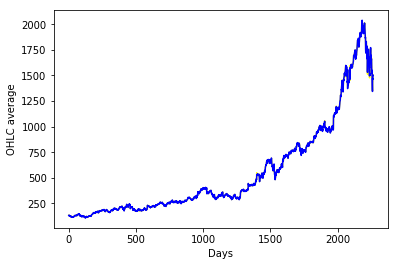

In [75]:
# PLOTTING All INDICATORS IN PLOT
plt.plot(OHLC_avg, 'yellow', label = 'OHLC avg')
plt.plot(close_val, 'blue', label = 'Closing price')
plt.xlabel('Days')
plt.ylabel('OHLC average')
plt.show()


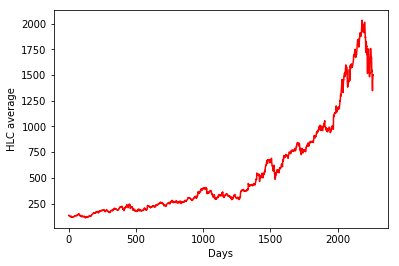

In [76]:
plt.plot(HLC_avg, 'red', label = 'HLC avg')
plt.xlabel('Days')
plt.ylabel('HLC average')
plt.show()


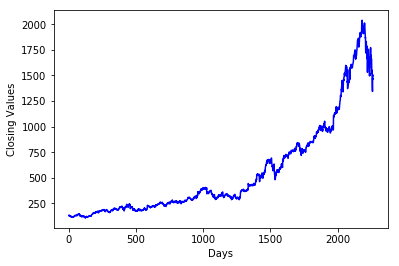

In [77]:
plt.plot(close_val, 'blue', label = 'Closing price')
plt.xlabel('Days')
plt.ylabel('Closing Values')
plt.show()

In [0]:
# PREPARATION OF TIME SERIES DATASE
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1)) 
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

In [0]:
# TRAIN-TEST SPLIT
train_OHLC = int(len(OHLC_avg) * 0.75)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

In [0]:
# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY = new_dataset(test_OHLC, 1)

In [0]:
# RESHAPING TRAIN AND TEST DATA
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1


In [0]:
# LSTM MODEL
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

In [83]:
# MODEL COMPILING AND TRAINING
model.compile(loss='mean_squared_error', optimizer='adagrad',metrics = ['mae']) # Try mae, adam, adagrad and compare!!!
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
 - 17s - loss: 0.0069 - mean_absolute_error: 0.0469
Epoch 2/50
 - 16s - loss: 3.2351e-04 - mean_absolute_error: 0.0151
Epoch 3/50
 - 16s - loss: 2.5536e-04 - mean_absolute_error: 0.0134
Epoch 4/50
 - 16s - loss: 2.0761e-04 - mean_absolute_error: 0.0119
Epoch 5/50
 - 16s - loss: 1.7103e-04 - mean_absolute_error: 0.0106
Epoch 6/50
 - 16s - loss: 1.4206e-04 - mean_absolute_error: 0.0095
Epoch 7/50
 - 16s - loss: 1.2193e-04 - mean_absolute_error: 0.0086
Epoch 8/50
 - 16s - loss: 1.0676e-04 - mean_absolute_error: 0.0079
Epoch 9/50
 - 16s - loss: 9.4709e-05 - mean_absolute_error: 0.0073
Epoch 10/50
 - 16s - loss: 8.5842e-05 - mean_absolute_error: 0.0068
Epoch 11/50
 - 16s - loss: 7.8493e-05 - mean_absolute_error: 0.0063
Epoch 12/50
 - 16s - loss: 7.2784e-05 - mean_absolute_error: 0.0059
Epoch 13/50
 - 16s - loss: 6.9067e-05 - mean_absolute_error: 0.0057
Epoch 14/50
 - 16s - loss: 6.5934e-05 - mean_absolute_error: 0.0054
Epoch 15/50
 - 16s - loss: 6.3742e-05 - mean_absolute_error: 

In [87]:
mae = model.evaluate(testX, testY, batch_size=16)
print('Mean Absolute Error for Y:', mae)

565/565 [==============================] - 0s 250us/step
Mean Absolute Error for Y: [9.329830344243025e-06, 0.0026545574847378034]


**The mean absolute error is lower than the past model with one feature. The errror is almost 0.0026. So the training model should be pretty close to testing model.**

In [0]:
# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [0]:
# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [90]:
# TRAINING rmse
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train : %.2f' % (trainScore))

Train : 14.47


In [91]:
# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

Test RMSE: 5.88


In [0]:
# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

In [0]:
# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

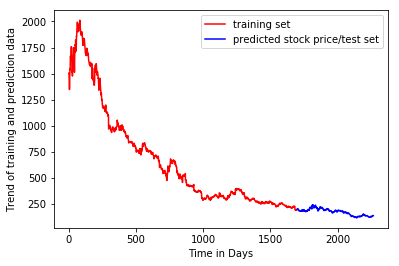

In [94]:
# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('Trend of training and prediction data')
plt.show()


**We trained our data for the first 1700 or so days and then tested for the rest. The prediction plot has kept up with the pattern how ever not to my satisfaction.**

In [95]:
# PREDICT FUTURE VALUES
last_val = testPredict[-1]
last_val_scaled = last_val/last_val
next_val = model.predict(np.reshape(last_val_scaled, (1,1,1)))
print("Last Day Value:", np.asscalar(last_val))
print("Next Day Value:", np.asscalar(last_val*next_val))
# print np.append(last_val, next_val)


Last Day Value: 139.6865234375
Next Day Value: 138.06378173828125


**The value  was found  relying on OHLC values. As the days increase the value is decreasing or rather stabilizing. However this is a wrong way of going about since amazon prices are still booming not decreasing.**

**Next notebook I'll focus on NOT overfitting the model and trying to get more data. Also I'll perform hyperparameter tuning and then try to PREDICT the STOCK PRICE MOVEMENT instead of the prices** 

  Code Ref for LSTM:
  
  https://github.com/LiamConnell/deep-algotrading
  
  https://keras.io/getting-started/sequential-model-guide/

**IN THE NEXT NOTEBOOK I AM GOING TO FOCUS MORE ON NORMALIZATION WITH HYPERPARAMTER TUNING AND LESS ON FEATURE EXTRACTION. THE REASON FOR THIS IS IT LOOKS LIKE A LSTM ESPECIALLY ON KERAS DOESN'T DO A GREAT JOB AT PREDICTING DAY TO DAY VALUES.**

**CONCLUSION FOR THIS NOTEBOOK:**

**1. FEATURES**:

**Focused on feature engineering and made a total of 19 features. Most of them were based on momentum and moving avaerage and EMA. Even Bollinger Bands were calculated**

**2. ARIMA MODEL**

**Got a great ARIMA model with less differemce AIC and BIC and P values close to the coefficient**

**3. FOURIER TRANSFORM MODEL**

**We got great predictions with Fourier Transform very close to the actual values**

**4. FEATURE ENGINEERING WITH XGBOOST**

**Refer to feature extraction graph where features are highest by their closeness to their Closing values. As predicted EMA is pretty high in this feature.** 

**5. LSTM MODEL WITH ONE FEATURE** 

**LSTM model with one feature did NOT give us the predictions we wanted.**

**6. LSTM MODEL WITH MULTIPLE FEATURES**

**LSTM model with multiple features again did not give us predictions we wanted.**

**I have come to the conclusion that LSTMs are not great at predicting Stock Prices when you just input stock price directly but rather better at predicting stock price movement over a long period of time.With the help of these movements we can calclate the price.**

**For this reason  I will use a larger dataset in the next notebook that can be observed for longer time and then predict stock price movement**
 
